<a href="https://colab.research.google.com/github/a20121248/aprendizaje_automatico/blob/main/Tarea_Linear_models_20121248_JM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regresión Lineal
En este laboratorio experimentaremos con el modelo de regresión lineal múltiple, implementando su propio modelo y comparándolo con el de SciKit Learn

In [66]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## House Sales Prediction Dataset

House Sales Prediction Data Set: https://www.kaggle.com/harlfoxem/housesalesprediction/home

Abstract: This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

- **id**: a notation for a house
- **date**: Date house was sold
- **price**: Price is prediction target
- **bedrooms**: Number of Bedrooms/House
- **bathrooms**: Number of bathrooms/bedrooms
- **sqft_living**: square footage of the home
- **sqft_lot**: square footage of the lot
- **floors**: Total floors (levels) in house
- **waterfront**: House which has a view to a waterfront
- **view**: Has been viewed
- **condition**: How good the condition is ( Overall )
- **grade**: overall grade given to the housing unit, based on King County grading system
- **sqft_above**: square footage of house apart from basement
- **sqft_basement**: square footage of the basement
- **yr_built**: Built Year
- **yr_renovated**: Year when house was renovated
- **zipcode**: zip
- **lat**: Latitude coordinate
- **long**: Longitude coordinate
- **sqft_living15**: Living room area in 2015(implies-- some renovations) This might or might not have affected the lotsize area
- **sqft_lot15**: lotSize area in 2015(implies-- some renovations)

In [7]:
df_raw_orig = pd.read_csv('kc_house_data.csv', parse_dates=['date'])
print(df_raw_orig.shape)
df_raw_orig.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503



### Preprocesamiento

In [23]:
df_raw = df_raw_orig.copy()

# Borramos la variable "id"
df_raw.drop('id', axis=1, inplace=True)

# Convertimos el target a escala logarítmica
df_raw['price'] = np.log(df_raw.price)

# Obtenemos atributos a partir de la fecha
date_attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
             'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

# NUEVO: El atributo week está deprecado en pandas, se usa el método isocalendar().week
for n in date_attr:
    if (n == 'Week'):
        df_raw['date_' + n] = df_raw['date'].dt.isocalendar().week.astype('int32')
    else:
        df_raw['date_' + n] = getattr(df_raw['date'].dt, n.lower())

df_raw['date_elapsed'] = df_raw['date'].astype(np.int64) // 10 ** 9

df_raw.drop('date', axis=1, inplace=True)

# "date_Is_year_start" tiene el mismo valor para todo el dataset
df_raw.drop('date_Is_year_start', axis=1, inplace=True)
df_raw.replace({True: 1, False: 0}, inplace=True)
df_raw.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_Year,date_Month,date_Week,date_Day,date_Dayofweek,date_Dayofyear,date_Is_month_end,date_Is_month_start,date_Is_quarter_end,date_Is_quarter_start,date_Is_year_end,date_elapsed
0,12.309982,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,42,13,0,286,0,0,0,0,0,1413158400
1,13.195614,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,50,9,1,343,0,0,0,0,0,1418083200
2,12.100712,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,9,25,2,56,0,0,0,0,0,1424822400
3,13.311329,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,50,9,1,343,0,0,0,0,0,1418083200
4,13.142166,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,8,18,2,49,0,0,0,0,0,1424217600


# **TAREA ACADÉMICA**

### Train-validation split

-  Separe el conjunto de datos (x) de la columna target (y)

- Divida el conjunto de datos en conjunto de entrenamiento (x_train, y_train) y conjunto de prueba (x_val, y_val)

In [110]:
from sklearn.model_selection import train_test_split

#########
#### aqui su código
target = 'price'
x = df_raw.drop(target, axis=1)
y = df_raw[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (17290, 30)
Validation shape: (4323, 30)


## Implementando mi propia función de Regresión lineal

### Implemento mi función de costo


In [25]:
##### Función de costo ##############
#### Aqui su código
def L(y, y_):
    return ((y - y_)**2).mean() / 2

### Implementando  la gradiente descendente
Desarrolle su propia función de costo considerando la implementación por matrices. Para ello utilice el conjunto de entrenamiento (x-train) como entrada para encontrar los parámetros w.

iter=0 / loss = 119.0232
iter=500 / loss = 12.5813
iter=1000 / loss = 1.8392
iter=1500 / loss = 0.3336
iter=2000 / loss = 0.1002
iter=2500 / loss = 0.0551
iter=3000 / loss = 0.0425
iter=3500 / loss = 0.0375
iter=4000 / loss = 0.0351
iter=4500 / loss = 0.0337
w = [ 0.00438238  0.00072314 -0.11744445  0.02006495  0.05153653  0.03368478
  0.04557156  0.05964775  0.16941333  0.22540867  0.13971472 -0.05455653
  0.03210596 -0.01308529  0.19699038 -0.01515769  0.08854682 -0.00995292
  0.61281219  0.14032622  0.14804781  0.01406     0.00183748  0.04635289
 -0.0089364  -0.00357275  0.01258935  0.00648567  0.02584594 -0.38337627]
b = 13.0446


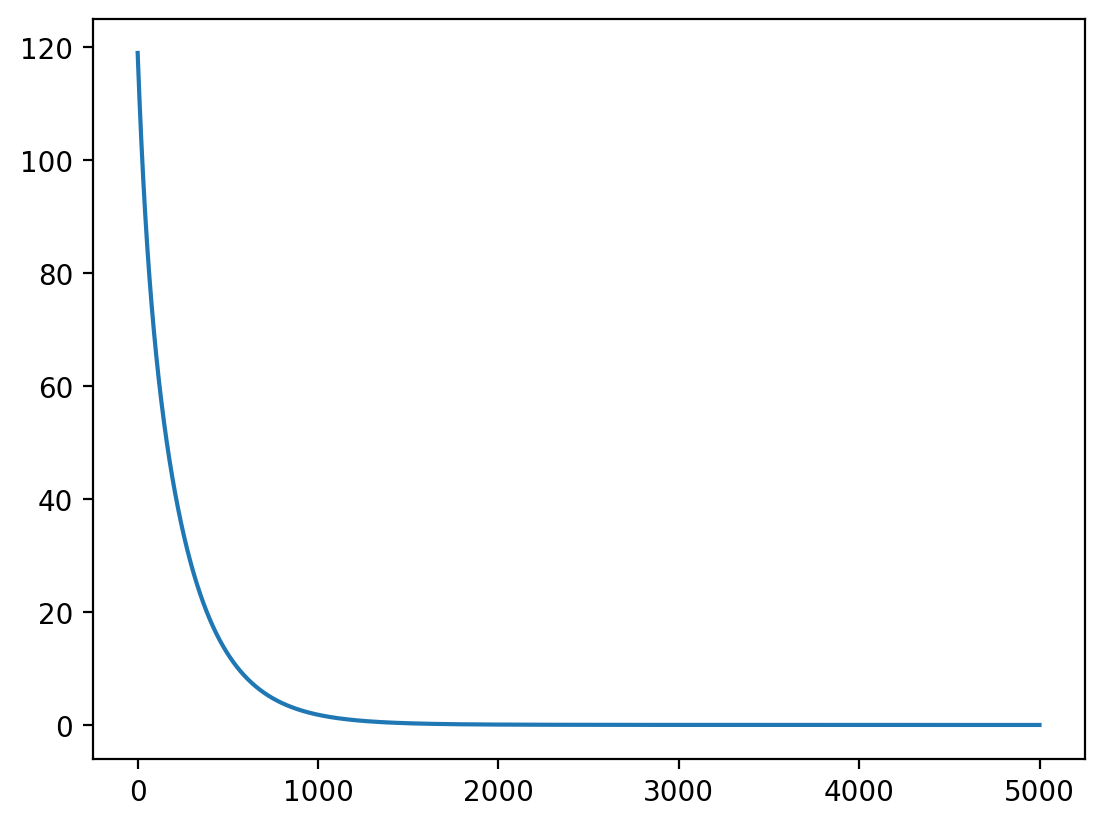

In [111]:
##### Función gradiente descendente ##############
#### Aqui su código
def gradients_matrices(x, y, y_):
    dw = (-2 * x.T @ (y - y_)[:, None]) / len(x)
    db = (-2 * (y - y_)).mean()
    return dw, db

# initial params
w = np.ones([x.shape[1],1])
b = 0
lr = 0.001
steps = 5000

def gradient_descent(x, y, w, b, lr, steps, debug=False):
    # Normalizar los inputs para evitar overflow y convergencia más rápida
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x = (x - mean) / std

    # Lo guardo para cuando llegue a scorear nueva data
    with open('mean.pkl', 'wb') as f:
        pickle.dump(mean, f)
    with open('std.pkl', 'wb') as f:
        pickle.dump(std, f)

    losses = []
    for i in range(steps):
        y_ = x @ w + b
        y_ = y_.ravel()
        loss = L(y, y_)
        losses.append(loss)
        dw, db = gradients_matrices(x, y, y_)
        w -= dw*lr
        b -= db*lr

        if (debug) and (i % 500 == 0):
            print(f"iter={i} / loss = {loss:.4f}")

    return w, b, losses

w_, b_, losses_ = gradient_descent(x_train.values, y_train.values, w, b, lr, steps, debug=True)
print(f'w = {w_.ravel()}')
print(f'b = {b_:.4f}')
plt.plot(losses_);

### Defina los parámetros que optimizan la regresión lineal de manera que permitan obtener los mejores parámetros W.


In [54]:
d_losess = {}
steps = 5000
rangos_lr = [0.1, 0.01, 0.001]
for lr in rangos_lr:
    # initial params
    w = np.ones([x.shape[1],1])
    b = 0

    w_, b_, losses_ = gradient_descent(x_train.values, y_train.values, w, b, lr, steps)
    d_losess[f'LR={str(lr)}'] = losses_

d_losess.keys()

dict_keys(['LR=0.1', 'LR=0.01', 'LR=0.001'])

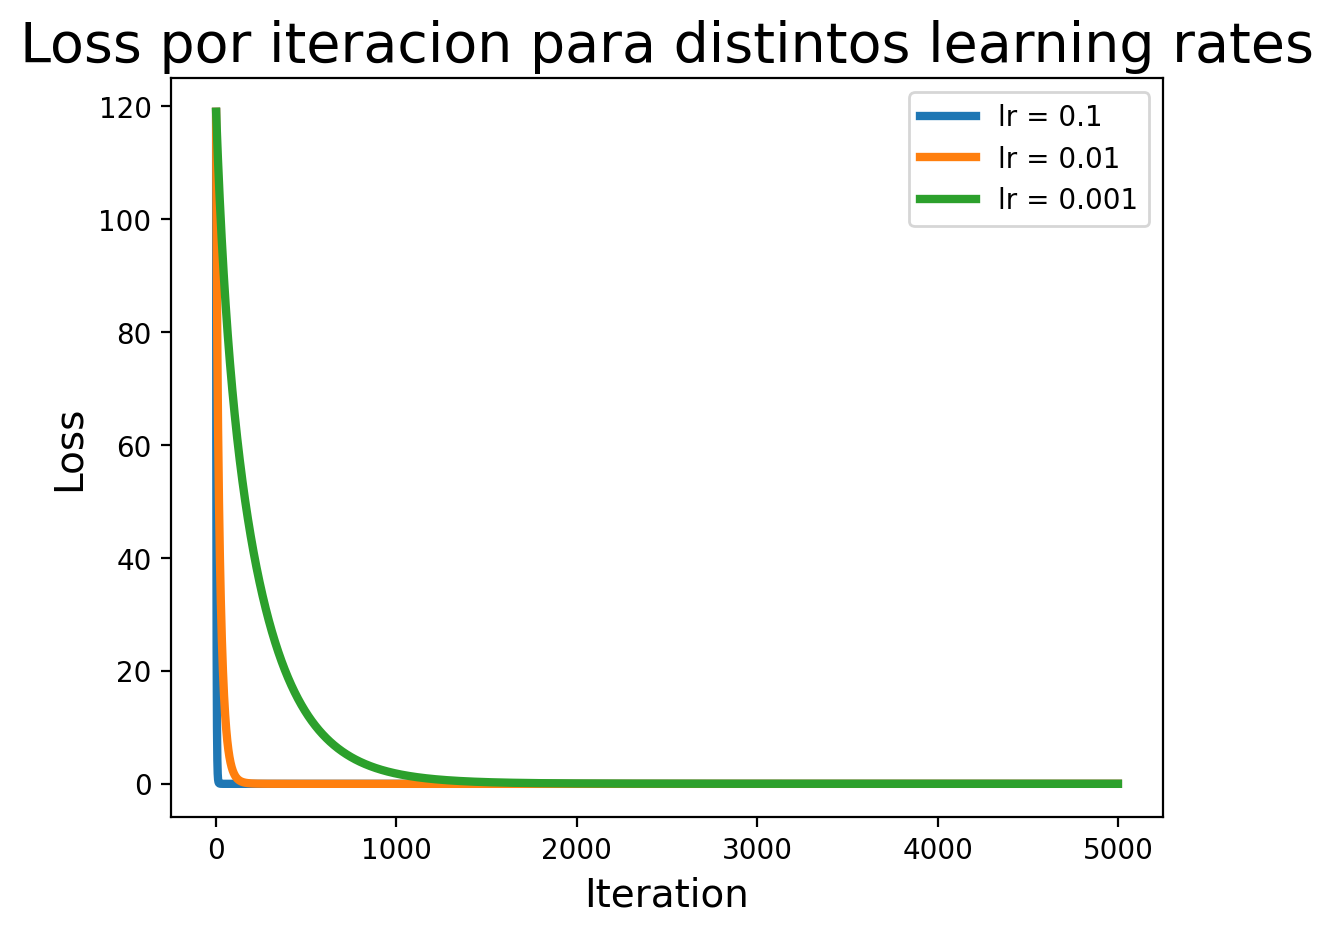

In [55]:
xs = np.arange(steps)
for _lr in rangos_lr:
  plt.plot(xs, d_losess[f'LR={str(_lr)}'], lw=3, label=f'lr = {str(_lr)}')

plt.title('Loss por iteracion para distintos learning rates', size=20)
plt.xlabel('Iteration', size=14)
plt.ylabel('Loss', size=14)
plt.legend()
plt.show()

### El mejor valor de w y b es

In [86]:
lr = 0.1
steps = 3000
w = np.zeros([x.shape[1],1])
b = 0
w_, b_, losses_ = gradient_descent(x_train.values, y_train.values, w, b, lr, steps)

print(f"b={b_}")
print(f"w={w_.flatten()}")

b=13.045165229875254
w=[ 0.20589699  0.01669855  0.03502292  0.26468541 -0.00361307  0.08174878
  0.06576944  0.07883692  0.00458361  0.00356283 -0.00284584  0.04056545
 -0.00196255 -0.03081721 -0.00474509]


### Probando el modelo
Encuentre el score del modelo usando el conjunto de entrenamiento (x_train) y el conjunto de prueba (x_val)

In [87]:
##### Hallando score del modelo ##############
#### Aqui su código
from sklearn.metrics import r2_score

def score_lr():
    # Cargo lo necesario para las transformaciones realizadas
    with open('mean.pkl', 'rb') as f:
        mean = pickle.load(f)

    with open('std.pkl', 'rb') as f:
        std = pickle.load(f)

    # Normalizar en los casos nuevos
    x_train_norm = (x_train - mean) / std
    x_val_norm = (x_val - mean) / std

    print(f"Score del modelo:")
    print(f"Train      = {r2_score(y_train, x_train_norm @ w_ + b_):.4f}")
    print(f"Validation = {r2_score(y_val  , x_val_norm   @ w_ + b_):.4f}")

score_lr()

Score del modelo:
Train      = 0.7088
Validation = 0.7157


## Comparamos con las funciones del SciKit Learn

###Linear regressión training with SciKit Learn

Entrene el modelo con el modelo de regresión lineal del SciKit Learn

In [112]:
from sklearn.linear_model import LinearRegression

#########
#### aqui su código

# Crear y entrenar el modelo
m = LinearRegression()
m.fit(x_train, y_train)

# Imprimir las variables y su respectivo coeficiente
print(f"Incercepto: {m.intercept_}")
coefficients_df = pd.DataFrame({'Variable': x.columns, 'Coefficient': m.coef_})
coefficients_df['Coefficient'] = coefficients_df['Coefficient'].map('{:.10f}'.format)
coefficients_df

Incercepto: -8.40233332829009


,Variable,Coefficient
0,bedrooms,-0.0115371542
1,bathrooms,0.0735137940
2,sqft_living,0.0000970871
3,sqft_lot,0.0000003969
4,floors,0.0756292783
5,waterfront,0.3762815531
6,view,0.0618101499
7,condition,0.0634679072
8,grade,0.1565918252
9,sqft_above,0.0000411258


In [115]:
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')

In [116]:
score()

Scores:
Train      = 0.7732
Validation = 0.7734


### verificamos el Error Cuadrátrico medio tanto para el conjunto de entrenamiento como para el de validación.

In [118]:
# Veamos el MSE
from sklearn.metrics import mean_squared_error
#########
#### aqui su código
def metrics():
    print(f'Error cuadrático medio (MSE):')
    print(f'Train      = {mean_squared_error(m.predict(x_train), y_train):.4}')
    print(f'Validation = {mean_squared_error(m.predict(x_val), y_val):.4}')

metrics()

Error cuadrático medio (MSE):
Train      = 0.06246
Validation = 0.06458


### Realizamos una selección de características, para ello usamos la función de importancia de características, que nos permite saber qué características son más discriminantes.

###Otorgue una explicación de las variables más discriminantes. Tienen un fundamento lógico?

In [119]:
imp = pd.DataFrame({'col':x_train.columns, 'importance':m.coef_}).sort_values('importance', ascending=False)
imp.style.bar()

,col,importance
14,lat,1.404497
19,date_Month,0.713560
5,waterfront,0.376282
8,grade,0.156592
4,floors,0.075629
1,bathrooms,0.073514
7,condition,0.063468
6,view,0.061810
26,date_Is_quarter_end,0.050213
27,date_Is_quarter_start,0.023173


###Cree un nuevo conjunto de entrenamiento y uno de prueba, eliminando aquellas características que tienen menos de 0.01 de valor de importancia.

In [120]:
##### Reducción de dimensionalidad ##############
#### Aqui su código
important_features = imp[abs(imp['importance']) > 0.01]['col'].tolist()
print(important_features)

['lat', 'date_Month', 'waterfront', 'grade', 'floors', 'bathrooms', 'condition', 'view', 'date_Is_quarter_end', 'date_Is_quarter_start', 'date_Day', 'bedrooms', 'date_Is_month_start', 'date_Dayofyear', 'long']


###con los nuevos conjuntos de entrenamiento y prueba reducidos, halle el score de  y los respectivos MSE. Compare con los resultados anteriores (data sin reducción de dimensionalidad). Puede usar las funciones de SciKit Learn.

In [122]:
##### Resultados con datos reducidos en su dimensionalidad ##############
#### Aqui su código
x = df_raw[important_features]
y = df_raw['price']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

# Crear y entrenar el modelo
m = LinearRegression()
m.fit(x_train, y_train)

print('')
score()

print('')
metrics()

Train shape     : (17290, 15)
Validation shape: (4323, 15)

Scores:
Train      = 0.7093
Validation = 0.7157

Error cuadrático medio (MSE):
Train      = 0.08008
Validation = 0.08105


###Otorgue una explicación sobre sus nuevos resultados, comparando los resultados obtenidos y analizando si el usar un número reducido de características no influenció dramáticamente en la predicción. ¿Por qué?

*Comentario: Se puede observar que los resultados son muy parecidos a entrenar con todas las variables. Esto podría indicar que no aportan valor al modelo o tal vez estuvieron muy correlacionadas, por lo que no aportan poder predictivo.*

*También es importante considerar que los pesos no necesariamente representan que una variable es mejor que otra dado que no están en la misma escala.*

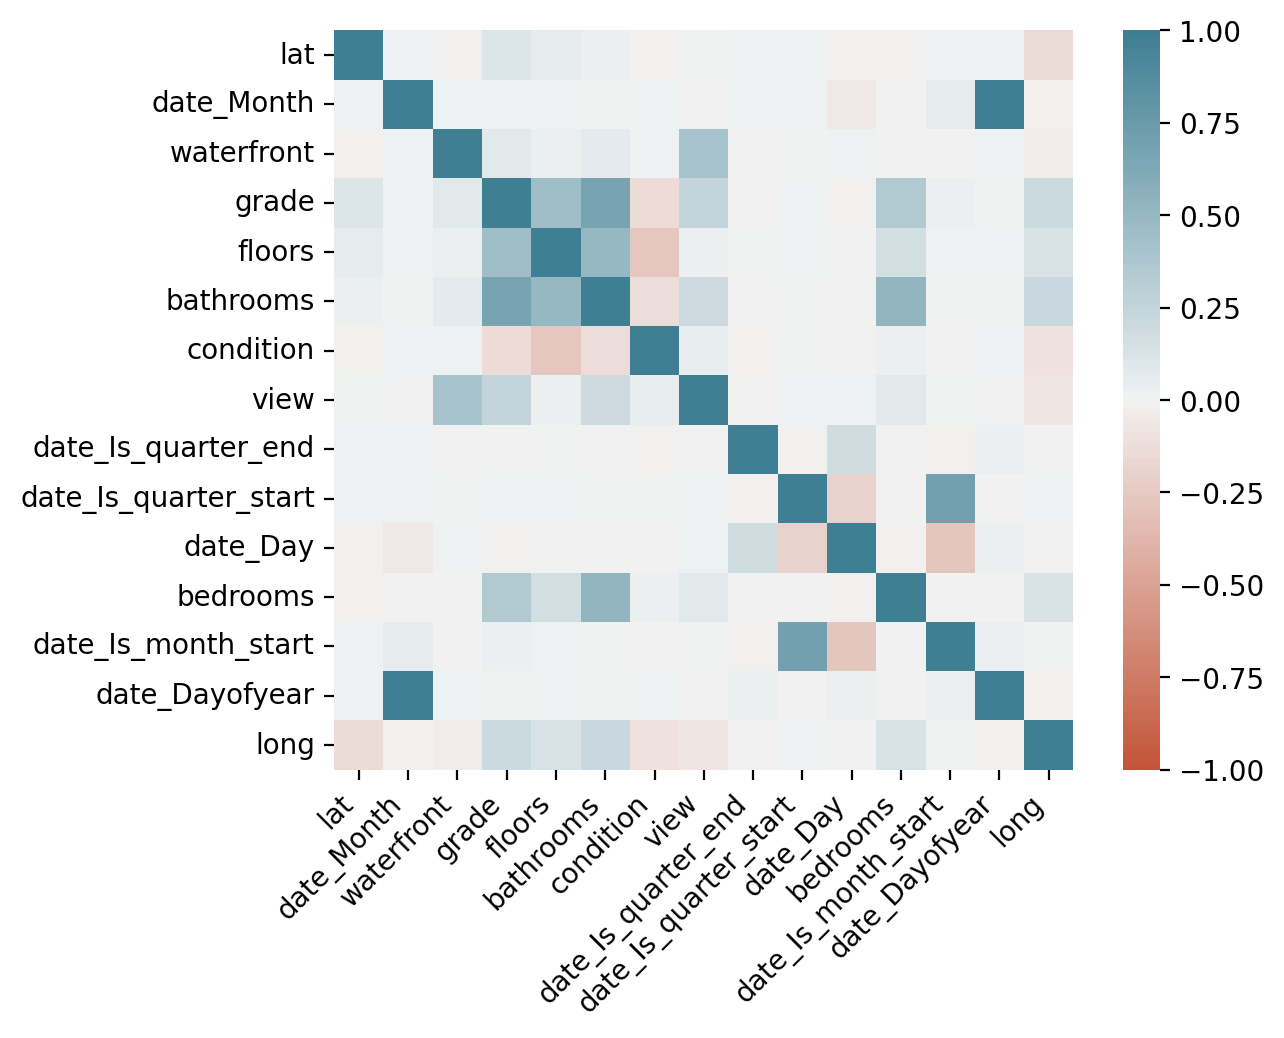

In [123]:
# Podria ver que unas variables estan muy correlacionadas

corr = x.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);